In [83]:
## Imports required for the project
import autograd.numpy as np
from autograd import grad 
import pandas as pd
import sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, auc, roc_auc_score, roc_curve, silhouette_score, rand_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
import matplotlib.pyplot as plt

In [84]:
%matplotlib inline
import pandas as pd

def read_data(file_path):
    return pd.read_csv(file_path, sep=',', header=0).fillna('')

def preprocessing(training, test):
    y_train = training['overall']
    xd_train = training['reviewText']
    xd_test = test['reviewText']
    xs_train = training['summary'].fillna('', inplace=False)
    xs_test = test['summary'].fillna('', inplace=False)
    return y_train, xd_train, xd_test, xs_train, xs_test

# Read in data
training = read_data('Training.csv')
test = read_data('Test.csv')

# Preprocess data, assign training and test values, and deal with 'nas'
y_train, xd_train, xd_test, xs_train, xs_test = preprocessing(training, test)

# Task 1: Binary Classification

#### Binary Cross Validation

In [85]:
def binary_cv(model, cutoff):
    # Define the number of folds and initialize results arrays
    num_folds = 5
    # Initialise results
    results = {
        'accuracy': np.zeros(num_folds),
        'precision': np.zeros(num_folds),
        'recall': np.zeros(num_folds),
        'f1': np.zeros(num_folds),
        'confusion': np.zeros((num_folds, 2, 2)),
        'rocauc': np.zeros(num_folds)
    }

    # Perform cross-validation
    # Fold
    fold = KFold(n_splits=num_folds)
    # Iterate over indices
    for i, (train_index, test_index) in enumerate(fold.split(training)):
        # Split the data into training and test sets
        train_data = training.loc[train_index]
        test_data = training.loc[test_index]

        # Apply the model and stroe predictions
        predictions = model(train_data, test_data, cutoff)

        # Compute labels and other metrics to evaluate
        labels = (test_data['overall'] > cutoff).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
        accuracy = accuracy_score(labels, predictions)
        rocauc = roc_auc_score(labels, predictions, average='macro')
        confusion = confusion_matrix(labels, predictions)

        # Store the results in results for all the metrics created above
        results['accuracy'][i] = accuracy
        results['precision'][i] = precision
        results['recall'][i] = recall
        results['f1'][i] = f1
        results['confusion'][i] = confusion
        results['rocauc'][i] = rocauc

    # Compute means
    f1_mean = np.mean(results['f1'])
    accuracy_mean = np.mean(results['accuracy'])
    precision_mean = np.mean(results['precision'])
    confusion_mean = np.mean(results['confusion'], axis=0)
    rocauc_mean = np.mean(results['rocauc'])

    # Print the results
    print("Mean Confusion Matrix:")
    for row in confusion_mean:
        print(row)
    print(f"Mean F1 Score: {f1_mean:.4f}")
    print(f"Mean Accuracy: {accuracy_mean:.4f}")
    print(f"Mean Precision: {precision_mean:.4f}")
    print(f"Mean ROC AUC Score: {rocauc_mean:.4f}\n")


#### Binary Logistic Regression

In [86]:
def binary_logistic_regression(train, test, cutoff):
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    yCutoff = np.where(yTrain <= cutoff, 0, np.where(yTrain > cutoff, 1, yTrain))

    # initialize vectorizers and transform data, parameter tuning
    revVectorizer = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.99, min_df = 0.15)
    sumVectorizer = TfidfVectorizer(ngram_range = (1, 2)) 
    
    # Store and fit data, stack tuned params
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    stack = hstack((reviewTextTrain, trainCap))
    
    # Transform test data and stack
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run logistic regression
    logistic_regression = LogisticRegression(C=2.5, max_iter=800).fit(stack, yCutoff)
    
    # Store and return y predicted values
    yPred = logistic_regression.predict(fT)
    return yPred

# Print info for logistic regression
print('Binary Logistic Regression\n\n')
for cutoff in range(1,5):
    print('Cutoff:', cutoff)
    binary_cv(binary_logistic_regression, cutoff)

    

Binary Logistic Regression


Cutoff: 1
Mean Confusion Matrix:
[793.2 398.2]
[  65.4 4581. ]
Mean F1 Score: 0.8631
Mean Accuracy: 0.9206
Mean Precision: 0.9182
Mean ROC AUC Score: 0.8294

Cutoff: 2
Mean Confusion Matrix:
[2175.2  208. ]
[ 145.4 3309.2]
Mean F1 Score: 0.9355
Mean Accuracy: 0.9395
Mean Precision: 0.9364
Mean ROC AUC Score: 0.9351

Cutoff: 3
Mean Confusion Matrix:
[3453.   102.6]
[ 216.  2066.2]
Mean F1 Score: 0.9410
Mean Accuracy: 0.9454
Mean Precision: 0.9452
Mean ROC AUC Score: 0.9378

Cutoff: 4
Mean Confusion Matrix:
[4650.4   59. ]
[329.6 798.8]
Mean F1 Score: 0.8783
Mean Accuracy: 0.9334
Mean Precision: 0.9290
Mean ROC AUC Score: 0.8455



#### Binary Linear SVC

In [87]:
def binary_linear_svc(train, test, cutoff):
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    y_cutoff = np.where(yTrain <= cutoff, 0, np.where(yTrain > cutoff, 1, yTrain))

    # initialize vectorizers and transform data, parameter tuning
    revVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.99, min_df=0.15) 
    sumVectorizer = TfidfVectorizer(ngram_range=(1, 2))

    # Store and fit data, stack tuned params
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    stack = hstack((reviewTextTrain, trainCap))
    
    # Transform test data and stack
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run linear svc and return y predicted values
    yPred = LinearSVC().fit(stack, y_cutoff).predict(fT)
    
    return yPred

# Print relevant binary linear SVC info
print('Binary Linear SVC\n\n')
for cutoff in range(1, 5):
    print('Cutoff:', cutoff)
    binary_cv(binary_linear_svc, cutoff)



Binary Linear SVC


Cutoff: 1
Mean Confusion Matrix:
[1104.2   87.2]
[  49.8 4596.6]
Mean F1 Score: 0.9618
Mean Accuracy: 0.9765
Mean Precision: 0.9666
Mean ROC AUC Score: 0.9573

Cutoff: 2
Mean Confusion Matrix:
[2326.    57.2]
[  56.4 3398.2]
Mean F1 Score: 0.9792
Mean Accuracy: 0.9805
Mean Precision: 0.9787
Mean ROC AUC Score: 0.9798

Cutoff: 3
Mean Confusion Matrix:
[3505.    50.6]
[  39.2 2243. ]
Mean F1 Score: 0.9835
Mean Accuracy: 0.9846
Mean Precision: 0.9828
Mean ROC AUC Score: 0.9843

Cutoff: 4
Mean Confusion Matrix:
[4663.    46.4]
[  62.8 1065.6]
Mean F1 Score: 0.9685
Mean Accuracy: 0.9813
Mean Precision: 0.9701
Mean ROC AUC Score: 0.9671



#### Binary Perceptron

In [88]:
def binary_perceptron(train, test, cutoff):
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    y_cutoff = np.where(yTrain <= cutoff, 0, np.where(yTrain > cutoff, 1, yTrain))

    # initialize vectorizers and transform data, parameter tuning
    revVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.99, min_df=0.15) 
    sumVectorizer = TfidfVectorizer(ngram_range=(1, 2))

    # Store and fit data, stack tuned params
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    stack = hstack((reviewTextTrain, trainCap))
    
    # Transform test data and stack
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run perceptron 
    perceptron = Perceptron(max_iter=10000)
    perceptron.fit(stack, y_cutoff)

    # Store and return predicted y values
    yPredicted = perceptron.predict(fT)
    
    return yPredicted

# Print relevant perceptron data
print('Binary Perceptron\n\n')
for cutoff in range(1, 5):
    print('Cutoff:', cutoff)
    binary_cv(binary_perceptron, cutoff)

Binary Perceptron


Cutoff: 1
Mean Confusion Matrix:
[1162.4   29. ]
[ 346.8 4299.6]
Mean F1 Score: 0.9042
Mean Accuracy: 0.9356
Mean Precision: 0.8746
Mean ROC AUC Score: 0.9504

Cutoff: 2
Mean Confusion Matrix:
[2331.6   51.6]
[ 165.2 3289.4]
Mean F1 Score: 0.9606
Mean Accuracy: 0.9629
Mean Precision: 0.9568
Mean ROC AUC Score: 0.9654

Cutoff: 3
Mean Confusion Matrix:
[3484.    71.6]
[  38.  2244.2]
Mean F1 Score: 0.9799
Mean Accuracy: 0.9812
Mean Precision: 0.9782
Mean ROC AUC Score: 0.9818

Cutoff: 4
Mean Confusion Matrix:
[4560.   149.4]
[  49.  1079.4]
Mean F1 Score: 0.9444
Mean Accuracy: 0.9660
Mean Precision: 0.9295
Mean ROC AUC Score: 0.9622



## Multiclass Classification

#### Multiclass cross validation

In [89]:
def multiclass_cv(model):
    # Store number of folds as per spec
    num_folds = 5

    # Initialise results
    results = {
        'accuracy': np.zeros(num_folds),
        'precision': np.zeros(num_folds),
        'recall': np.zeros(num_folds),
        'f1': np.zeros(num_folds),
        'confusion': np.zeros((num_folds, 5, 5)),
        'rocauc': np.zeros(num_folds)
    }
    # Fold data
    fold = KFold(n_splits=num_folds)

    # Iterate through test and train indices
    for i, (train_index, test_index) in enumerate(fold.split(training)):
        
        # Split the data into training and test sets
        train_data = training.loc[train_index]
        test_data = training.loc[test_index]

        # Store predictions and labels
        predictions, prob = model(train_data, test_data)
        labels = np.array(test_data['overall'])

        # Store evaluation metrics on the data
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=1)
        accuracy = accuracy_score(labels, predictions)
        rocauc = roc_auc_score(labels, prob, multi_class='ovr')
        confusion = confusion_matrix(labels, predictions)

        # Store the relevant in results
        results['accuracy'][i] = accuracy
        results['precision'][i] = precision
        results['recall'][i] = recall
        results['f1'][i] = f1
        results['confusion'][i] = confusion
        results['rocauc'][i] = rocauc

    # Get means for data reporting
    f1_mean = np.mean(results['f1'])
    accuracy_mean = np.mean(results['accuracy'])
    precision_mean = np.mean(results['precision'])
    confusion_mean = np.mean(results['confusion'], axis=0)
    rocauc_mean = np.mean(results['rocauc'])

    # Populate values list for printing data
    vals = [f1_mean, accuracy_mean, precision_mean, rocauc_mean]

    print('Confusion Matrix (Mean):')
    for row in confusion_mean:
        print(row)
    print(f'F1 Score (Mean): {vals[0]:.4f}')
    print(f'Accuracy (Mean): {vals[1]:.4f}')
    print(f'Precision (Mean): {vals[2]:.4f}')
    print(f'ROC AUC Score (Mean): {vals[3]:.4f}\n')


In [90]:
# Preprocess data
yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)

# Tuning and storing
revVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.99, min_df=0.15)
sumVectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Stack features appropriately
reviewTextTrain = revVectorizer.fit_transform(xdTrain)
trainCap = sumVectorizer.fit_transform(xsTrain)
trainedFeatures = hstack((reviewTextTrain, trainCap))

#### Multiclass Logistic Regression

In [91]:
def multiclass_logistic_regression(train, test):
    # Preprocess and tune
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    revVectorizer = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.99, min_df = 0.15) 
    sumVectorizer = TfidfVectorizer(ngram_range = (1, 2)) 
    
    # Store and fit train data, stack parmas
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    stack = hstack((reviewTextTrain, trainCap))
    
    # Transform test data and stack 
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run logistic regression
    logisticRegression = LogisticRegression(max_iter=800).fit(stack, yTrain)
    
    # Store predicted vals and return them
    yPred = logisticRegression.predict(fT)
    yProb = logisticRegression.predict_proba(fT)
    
    return yPred, yProb

# Print relevant multiclass logistic relevant info
print('Multiclass Logistic Regression\n')
multiclass_cv(multiclass_logistic_regression)

Multiclass Logistic Regression

Confusion Matrix (Mean):
[1031.8   85.6   31.4   25.    17.6]
[102.6 965.   70.2  34.   20. ]
[ 52.4  79.8 934.6  64.6  41. ]
[ 27.2  32.   59.6 937.6  97.4]
[ 21.2  17.2  25.6  80.4 984. ]
F1 Score (Mean): 0.8250
Accuracy (Mean): 0.8313
Precision (Mean): 0.8214
ROC AUC Score (Mean): 0.9615



#### Logistic Regression Plot:

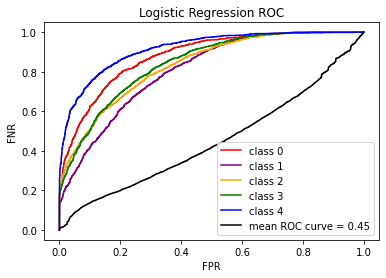

In [92]:
def logistic_plot(x, y):
    # Split data into training and test
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)
    
    # Initialize colours for the graph
    colors = ['red', 'purple', 'orange', 'green', 'blue']

    # Store y Score
    yScore = LogisticRegression(max_iter=800).fit(xTrain, yTrain).predict_proba(xTest)  
    
    # Initialize values to plot
    fpr = {}
    tpr = {}
    rocauc = {}
    YTest = []
    YScore = []
    
    # Figure out false positive rate, true positive rate, and ROC AUC for each class
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(yTest, yScore[:, i], pos_label=i+1)
        rocauc[i] = auc(fpr[i], tpr[i])
        YTest.extend(yTest)
        YScore.extend(yScore[:, i])
        
    # Calculate the overall false positive rate, true positive rate, ROC AUC
    fprMean, tprMean, _ = roc_curve(YTest, YScore, pos_label=i+1)
    rocaucMean = auc(fprMean, tprMean)
    
    # Create a figure and axes for the plot
    fig, ax = plt.subplots()
    
    # Plot each class
    for i in range(5):
        ax.plot(fpr[i], tpr[i], color=colors[i], label='class ' + str(i))
    
    # Plot average
    ax.plot(fprMean, tprMean, color='black', label='mean ROC curve = {0:0.2f}'.format(rocaucMean))
    
    # Set labels and title
    ax.set_title("Logistic Regression ROC")
    ax.set_xlabel("FPR")
    ax.set_ylabel("FNR")
    
    # Show the legend
    ax.legend()
    
    # Display the plot
    plt.show()

logistic_plot(trainedFeatures, yTrain)


#### Linear SVC

In [93]:
def multiclass_linearsvc(train, test):
    # Preprocess and tune
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    revVectorizer = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.99, min_df = 0.15) 
    sumVectorizer = TfidfVectorizer(ngram_range = (1, 2)) 
    
    # Transform and stack strain data
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    stack = hstack((reviewTextTrain, trainCap))
    
    # Transform and stack test data
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run linear svc
    linearSVC = LinearSVC(max_iter=800).fit(stack, yTrain)
    
    # Store and return y pred and prob
    yPred = linearSVC.predict(fT)
    yProb = CalibratedClassifierCV(linearSVC).fit(stack, yTrain).predict_proba(fT)
    
    return yPred, yProb

# Print relevant multiclass linear SVC info
print('Multiclass Linear SVC\n')
multiclass_cv(multiclass_linearsvc)

Multiclass Linear SVC

Confusion Matrix (Mean):
[1133.2   48.     4.6    2.     3.6]
[  52.  1108.    25.4    2.8    3.6]
[  10.    34.2 1090.4   26.4   11.4]
[   2.     4.    16.8 1085.4   45.6]
[1.0000e+00 1.2000e+00 2.8000e+00 3.3800e+01 1.0896e+03]
F1 Score (Mean): 0.9409
Accuracy (Mean): 0.9433
Precision (Mean): 0.9388
ROC AUC Score (Mean): 0.9912



#### Linear SVC plot

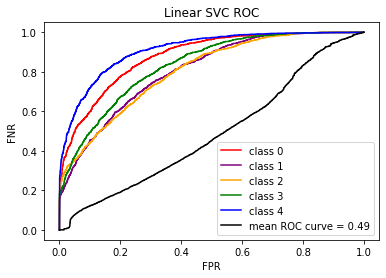

In [94]:
def linear_plot(x, y):
    # Split data into training and test
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)
    
    # Initialize colours for the graph
    colors = ['red', 'purple', 'orange', 'green', 'blue']

    # Store y Score
    yScore = CalibratedClassifierCV(LinearSVC(max_iter=800)).fit(xTrain, yTrain).predict_proba(xTest)  

    # Initialize values to plot
    fpr = {}
    tpr = {}
    rocauc = {}
    YTest = []
    YScore = []
    
    # Individual curves
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(yTest, yScore[:, i], pos_label=i+1)
        rocauc[i] = auc(fpr[i], tpr[i])
        
        YTest.extend(yTest)
        YScore.extend(yScore[:, i])
        
    # Calculate the overall false positive rate, true positive rate, ROC AUC
    fprMean, tprMean, _ = roc_curve(YTest, YScore, pos_label=i+1)
    rocaucMean = auc(fprMean, tprMean)
    
    # Create a figure and axes for the plot
    fig, ax = plt.subplots()
            
    # Individual curves
    for i in range(5):
        ax.plot(fpr[i], tpr[i], color=colors[i], label='class ' + str(i))
    
    # Average curve
    ax.plot(fprMean, tprMean, color='black', label='mean ROC curve = {0:0.2f}'.format(rocaucMean))
    
    # Set labels and title
    ax.set_title("Linear SVC ROC")
    ax.set_xlabel("FPR")
    ax.set_ylabel("FNR")
    
    # Show the legend
    ax.legend()
    
    # Display the plot
    plt.show()

linear_plot(trainedFeatures, yTrain)

#### Perceptron

In [95]:
def multiclass_perceptron(train, test):
    # Preprocess and utne
    yTrain, xdTrain, xdTest, xsTrain, xsTest = preprocessing(training, test)
    revVectorizer = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.99, min_df = 0.15) 
    sumVectorizer = TfidfVectorizer(ngram_range = (1, 2)) 
    
    # Transform and stack train data
    reviewTextTrain = revVectorizer.fit_transform(xdTrain)
    trainCap = sumVectorizer.fit_transform(xsTrain)
    trainedFeatures = hstack((reviewTextTrain, trainCap))

    # Transform and stack test data   
    dT = revVectorizer.transform(xdTest)
    sT = sumVectorizer.transform(xsTest)
    fT = hstack((dT, sT))
    
    # Run perceptron
    perceptron = Perceptron(max_iter=800).fit(trainedFeatures, yTrain)
    
    # Store and return yPred and yProb
    yPred = perceptron.predict(fT)
    yProb = CalibratedClassifierCV(perceptron).fit(trainedFeatures, yTrain).predict_proba(fT)
    
    return yPred, yProb

# Print relevant perceptron info
print('Multiclass Perceptron\n')
multiclass_cv(multiclass_perceptron)

Multiclass Perceptron

Confusion Matrix (Mean):
[1109.2   62.4   12.2    3.     4.6]
[  47.4 1093.4   41.6    5.2    4.2]
[  11.2   20.8 1108.2   23.     9.2]
[   1.6    3.2   26.8 1079.8   42.4]
[   1.8    1.2    8.    44.2 1073.2]
F1 Score (Mean): 0.9335
Accuracy (Mean): 0.9359
Precision (Mean): 0.9312
ROC AUC Score (Mean): 0.9940



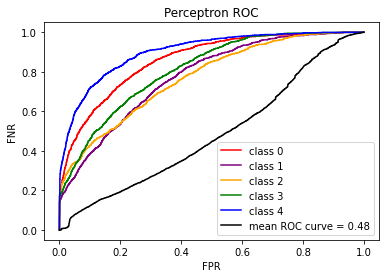

In [96]:
def perceptron_plot(x, y):
    # Split data into training and test
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)

    # Initialize colors for the graph
    colors = ['red', 'purple', 'orange', 'green', 'blue']

    # Store y Score
    yScore = CalibratedClassifierCV(Perceptron(max_iter=800)).fit(xTrain, yTrain).predict_proba(xTest)

    # Initialize values to plot
    fpr = {}
    tpr = {}
    rocauc = {}
    YTest = []
    YScore = []

    # Individual curves
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(yTest, yScore[:, i], pos_label=i + 1)
        rocauc[i] = auc(fpr[i], tpr[i])

        YTest.extend(yTest)
        YScore.extend(yScore[:, i])

    # Calculate the overall false positive rate, true positive rate, ROC AUC
    fprMean, tprMean, _ = roc_curve(YTest, YScore, pos_label=i + 1)
    rocaucMean = auc(fprMean, tprMean)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots()

    # Individual curves
    for i in range(5):
        ax.plot(fpr[i], tpr[i], color=colors[i],
                label='class ' + str(i))

    # Average curve
    ax.plot(fprMean, tprMean, color='black', label='mean ROC curve = {0:0.2f}'.format(rocaucMean))

    # Set labels and title
    ax.set_title("Perceptron ROC")
    ax.set_xlabel("FPR")
    ax.set_ylabel("FNR")

    # Show the legend
    ax.legend()

    # Display the plot
    plt.show()


perceptron_plot(trainedFeatures, yTrain)


### Clustering

In [97]:
# Read data
clusterTest = pd.read_csv('Test.csv', sep=',', header=0).fillna('')

# Store review text and categories
x = clusterTest['reviewText']
categories = clusterTest['category']

# TF-IDF vectorization, tuning
cVectorizer = TfidfVectorizer(stop_words='english', max_df=0.99, min_df=0.15)
xFeatures = cVectorizer.fit_transform(x)

# Use k-means clustering on the review text
kmeans_reviewText = KMeans(n_clusters=len(set(categories))).fit(xFeatures)

# Use K-means clustering on the categories
cVectorizer_categories = TfidfVectorizer(stop_words='english')
cFeatures = cVectorizer_categories.fit_transform(categories)
kmeans_categories = KMeans(n_clusters=len(set(categories))).fit(cFeatures)

# Store the Silhouette score of reviewText clustering
silhouette_score_reviewText = silhouette_score(xFeatures, kmeans_reviewText.labels_)

# Store Rand score of the two clusterings
rand_score_categories = rand_score(kmeans_reviewText.labels_, kmeans_categories.labels_)

# Print the relevant info
print("Silhouette Score (reviewText): ", silhouette_score_reviewText)
print("Rand Score (reviewText and categories): ", rand_score_categories)

Silhouette Score (reviewText):  0.8211435446568216
Rand Score (reviewText and categories):  0.6416469832802351


#### Kaggle

In [98]:
# Read in the data
test = pd.read_csv('Test.csv',sep=',',header=0)

# cutoffs
for i in range(1, 5):
    testPredicted = binary_linear_svc(training, test, i) #linear svc - best performing
    testFile = 'Binary_Classifier_' + str(i) + 'Submission.csv'
    submission = pd.DataFrame({'id': range(len(testPredicted)), 'binary_split_' + str(i): testPredicted}).to_csv(f'{testFile}', index=False)

In [100]:
# code sourced from Kaggle video
test = pd.read_csv('Test.csv', sep = ',', header = 0)

yPredicted, yProbability = multiclass_linearsvc(training, test) #linear svc - best performing
testFile = 'Multiclass_Classifier_Submission.csv'
submission = pd.DataFrame({'id': range(len(testPredicted)), 'label': yPredicted})

submission.to_csv(f'{testFile}', index=False)